In [8]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as df
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [38]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-11-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, 
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-28 A        40.981743   43.599998   44.689999   43.580002   44.520000   
           AAPL     25.831570   27.892500   28.117500   27.847500   27.857500   
           ABBV     42.172962   59.459999   59.939999   59.009998   59.130001   
           ABT      33.519829   38.740002   39.220001   38.700001   39.220001   
           ACGL     25.870779   27.206667   27.406668   27.116667   27.343332   
...                       ...         ...         ...         ...         ...   
2024-11-22 XYL     126.515785  126.870003  127.730003  125.760002  126.139999   
           YUM     134.617691  135.270004  135.869995  134.179993  134.529999   
           ZBH     110.220001  110.220001  110.370003  108.669998  108.669998   
           ZBRA    397.190002  397.190002  397.839996  392.540009  394.279999   
           ZTS     176.960007  176.960007  178.070007  176.279999  176.350006   

Price                   volume  
date       ticker               
2016-11-28 A         2241800.0  
           AAPL    108776000.0  
           ABBV      6274600.0  
           ABT       5727800.0  
           ACGL      1845000.0  
...                        ...  
2024-11-22 XYL       1365600.0  
           YUM        992500.0  
           ZBH       2015000.0  
           ZBRA       232000.0  
           ZTS       1854600.0  

[989262 rows x 6 columns]

## Calculate features and technical indicators for each stock.
##### Garman-Klass Volatlity
##### RSI
##### Bollinger Bands
##### ATR
##### MACD 
##### Dollar Volume

In [39]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
   atr = pandas_ta.atr(high=stock_data['high'],
                       low=stock_data['low'],
                       close=stock_data['close'],
                      length=14)
   return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
   macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
   return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-28 A        40.981743   43.599998   44.689999   43.580002   44.520000   
           AAPL     25.831570   27.892500   28.117500   27.847500   27.857500   
           ABBV     42.172962   59.459999   59.939999   59.009998   59.130001   
           ABT      33.519829   38.740002   39.220001   38.700001   39.220001   
           ACGL     25.870779   27.206667   27.406668   27.116667   27.343332   
...                       ...         ...         ...         ...         ...   
2024-11-22 XYL     126.515785  126.870003  127.730003  125.760002  126.139999   
           YUM     134.617691  135.270004  135.869995  134.179993  134.529999   
           ZBH     110.220001  110.220001  110.370003  108.669998  108.669998   
           ZBRA    397.190002  397.190002  397.839996  392.540009  394.279999   
           ZTS     176.960007  176.960007  178.070007  176.279999  176.350006   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-11-28 A         2241800.0         -0.002333        NaN       NaN   
           AAPL    108776000.0         -0.002156        NaN       NaN   
           ABBV      6274600.0         -0.043999        NaN       NaN   
           ABT       5727800.0         -0.009439        NaN       NaN   
           ACGL      1845000.0         -0.001127        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-22 XYL       1365600.0          0.000117  48.788614  4.778288   
           YUM        992500.0          0.000078  52.082158  4.878772   
           ZBH       2015000.0          0.000043  54.438181  4.658121   
           ZBRA       232000.0          0.000069  60.907590  5.914542   
           ZTS       1854600.0          0.000046  44.642241  5.147016   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-11-28 A            NaN       NaN       NaN       NaN      91.872871  
           AAPL         NaN       NaN       NaN       NaN    2809.854823  
           ABBV         NaN       NaN       NaN       NaN     264.618469  
           ABT          NaN       NaN       NaN       NaN     191.994875  
           ACGL         NaN       NaN       NaN       NaN      47.731587  
...                     ...       ...       ...       ...            ...  
2024-11-22 XYL     4.826566  4.874844  0.626261 -1.179897     172.769956  
           YUM     4.903059  4.927346  0.712395 -0.225595     133.608058  
           ZBH     4.699571  4.741022 -0.590623  0.465294     222.093302  
           ZBRA    5.964976  6.015410  0.087145  0.531073      92.148081  
           ZTS     5.180613  5.214210  0.660563 -1.215823     328.190028  

[989262 rows x 14 columns]

## Aggregate monthly levels and indicators to filter the top 150 most liquid stocks

In [40]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('ME').last().stack('ticker')],
         axis=1).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-01-31 A          102.349493   46.162552         -0.000339  61.726317   
           AAPL      3120.691543   28.095905         -0.002159  71.538251   
           ABBV       344.889487   43.780575         -0.038072  49.986838   
           ABT        371.924553   36.375008         -0.004523  72.328425   
           ACGL        29.688113   28.003962         -0.001044  61.679154   
...                          ...         ...               ...        ...   
2024-11-30 XYL        203.028004  126.515785          0.000117  48.788614   
           YUM        268.905397  134.617691          0.000078  52.082158   
           ZBH        180.060551  110.220001          0.000043  54.438181   
           ZBRA       149.927101  397.190002          0.000069  60.907590   
           ZTS        528.385041  176.960007          0.000046  44.642241   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.803595  3.833158  3.862721 -1.381981  0.136707  
           AAPL    3.327728  3.356231  3.384733 -1.446601 -0.131992  
           ABBV    3.779777  3.810983  3.842188 -1.438255 -0.325409  
           ABT     3.557928  3.591215  3.624503 -1.412058  0.188884  
           ACGL    3.331300  3.355690  3.380080 -1.172477 -0.008442  
...                     ...       ...       ...       ...       ...  
2024-11-30 XYL     4.778288  4.826566  4.874844  0.626261 -1.179897  
           YUM     4.878772  4.903059  4.927346  0.712395 -0.225595  
           ZBH     4.658121  4.699571  4.741022 -0.590623  0.465294  
           ZBRA    5.914542  5.964976  6.015410  0.087145  0.531073  
           ZTS     5.147016  5.180613  5.214210  0.660563 -1.215823  

[46730 rows x 9 columns]

## Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [41]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-12-31 AAPL     39.811523         -0.001775  47.784482  3.698682   
           ABBV     71.096024         -0.039988  55.000875  4.253741   
           ABT      50.525505         -0.006559  59.877703  3.884984   
           ACN     137.983643         -0.004850  65.003774  4.891671   
           ADBE    175.240005          0.000056  51.008416  5.137116   
...                       ...               ...        ...       ...   
2024-11-30 VZ       43.150002          0.000209  57.378871  3.713802   
           WFC      75.959999          0.000075  74.391809  4.137442   
           WMT      90.240067          0.000209  74.711050  4.392675   
           XOM     121.790001          0.000082  57.448623  4.751835   
           ZTS     176.960007          0.000046  44.642241  5.147016   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-12-31 AAPL    3.724109  3.749537 -1.257444 -0.269463  
           ABBV    4.278529  4.303317 -0.924108  0.077111  
           ABT     3.922018  3.959052 -1.373007  0.164544  
           ACN     4.921786  4.951901 -1.162140  0.224442  
           ADBE    5.167383  5.197650 -1.354089 -0.179053  
...                     ...       ...       ...       ...  
2024-11-30 VZ      3.747945  3.782089 -0.331598 -0.043189  
           WFC     4.260497  4.383553  1.816726  3.702242  
           WMT     4.445013  4.497350  2.702822  2.779545  
           XOM     4.786490  4.821145  0.427473  0.439478  
           ZTS     5.180613  5.214210  0.660563 -1.215823  

[12516 rows x 8 columns]

## Calculate Monthly returns for different time horizons as features

In [42]:
def calculate_returns(df):
    
    outlier_cutoff = 0.005
    
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))

    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-12-31 AAPL     37.665619         -0.000835  37.072851  3.585046   
           ABBV     70.416023         -0.026539  57.957299  4.152361   
           ABT      65.209145         -0.003189  55.190127  4.111693   
           ACN     129.389069         -0.002485  36.633876  4.807611   
           ADBE    226.240005          0.000161  46.330419  5.329066   
...                       ...               ...        ...       ...   
2024-11-30 VRTX    450.970001          0.000155  41.136384  6.090617   
           VZ       43.150002          0.000209  57.378871  3.713802   
           WFC      75.959999          0.000075  74.391809  4.137442   
           WMT      90.240067          0.000209  74.711050  4.392675   
           XOM     121.790001          0.000082  57.448623  4.751835   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-12-31 AAPL    3.697134  3.809221 -0.672172 -1.246500  -0.116698   
           ABBV    4.223280  4.294199  0.748414 -0.103455  -0.022064   
           ABT     4.169437  4.227180  0.308224 -0.322310  -0.023228   
           ACN     4.940240  5.072869 -0.151647 -1.466668  -0.142900   
           ADBE    5.452557  5.576047 -0.042862 -0.755168  -0.098250   
...                     ...       ...       ...       ...        ...   
2024-11-30 VRTX    6.170690  6.250762  2.751680 -1.830256  -0.052544   
           VZ      3.747945  3.782089 -0.331598 -0.043189   0.024211   
           WFC     4.260497  4.383553  1.816726  3.702242   0.176797   
           WMT     4.445013  4.497350  2.702822  2.779545   0.103600   
           XOM     4.786490  4.821145  0.427473  0.439478   0.051471   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132912  -0.101245  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024292  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054156  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-11-30 VRTX    -0.015286  -0.031155  -0.001606   0.007739    0.020186  
           VZ      -0.012169   0.016046   0.013284   0.013771    0.015363  
           WFC      0.162932   0.093240   0.042643   0.037496    0.047667  
           WMT      0.058301   0.054043   0.055049   0.050330    0.044398  
           XOM      0.023486   0.013526   0.009059   0.019885    0.017115  

[10375 rows x 14 columns]

### Download Fama-French Factors and Calculate rolling factor betas

In [43]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start="2010")[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()


In [44]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142900
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VRTX   -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.023437
           VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[10233 rows x 6 columns]

#### Filter out stocks with less than 10 months of data

In [45]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

#### Calculate rolling factor betas

In [46]:
betas = (factor_data.groupby(level=1, 
                    group_keys=False)
.apply(lambda x: RollingOLS(endog=x['return_1m'],
                            exog=sm.add_constant(x.drop('return_1m', axis=1)),
                            window=min(24, x.shape[0]),
                            min_nobs=len(x.columns)+1)
.fit(params_only=True)
.params
.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VRTX    0.875565  0.561738 -0.138340  1.074647 -0.149229
           VZ      0.734852 -0.727650  0.404497  0.236658  0.079246
           WFC     0.938968 -0.274122  1.298547 -1.246689 -0.662805
           WMT     0.647143 -0.013020 -0.188276  1.055353  0.075125
           XOM     0.366522 -0.109621  0.369991  0.571945  0.339941

[10198 rows x 5 columns]

In [54]:
factors = ['Mkt-RF', 'SMB',  'HML', 'RMW', 'CMA']

data = data.join(betas.groupby('ticker').shift())

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10136 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-11-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10136 non-null  float64
 1   rsi               10136 non-null  float64
 2   bb_low            10136 non-null  float64
 3   bb_mid            10136 non-null  float64
 4   bb_high           10136 non-null  float64
 5   atr               10136 non-null  float64
 6   macd              10136 non-null  float64
 7   return_1m         10136 non-null  float64
 8   return_2m         10136 non-null  float64
 9   return_3m         10136 non-null  float64
 10  return_6m         10136 non-null  float64
 11  return_9m         10136 non-null  float64
 12  return_12m        10136 non-null  float64
 13  Mkt-RF            10136 non-null  float64
 14  SMB               10136 non-null  float64
 15  HML       

## Create K-means clustering to determine our portfolio

#### Create pre-defined centroids

In [64]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-12-31 AAPL           -0.000835  37.072851  3.585046  3.697134  3.809221   
           ABBV           -0.026539  57.957299  4.152361  4.223280  4.294199   
           ABT            -0.003189  55.190127  4.111693  4.169437  4.227180   
           ACN            -0.002485  36.633876  4.807611  4.940240  5.072869   
           ADBE            0.000161  46.330419  5.329066  5.452557  5.576047   
...                             ...        ...       ...       ...       ...   
2024-11-30 VRTX            0.000155  41.136384  6.090617  6.170690  6.250762   
           VZ              0.000209  57.378871  3.713802  3.747945  3.782089   
           WFC             0.000075  74.391809  4.137442  4.260497  4.383553   
           WMT             0.000209  74.711050  4.392675  4.445013  4.497350   
           XOM             0.000082  57.448623  4.751835  4.786490  4.821145   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.672172 -1.246500  -0.116698  -0.132912  -0.101245   
           ABBV    0.748414 -0.103455  -0.022064   0.088210  -0.004972   
           ABT     0.308224 -0.322310  -0.023228   0.024292  -0.003340   
           ACN    -0.151647 -1.466668  -0.142900  -0.054156  -0.057936   
           ADBE   -0.042862 -0.755168  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-11-30 VRTX    2.751680 -1.830256  -0.052544  -0.015286  -0.031155   
           VZ     -0.331598 -0.043189   0.024211  -0.012169   0.016046   
           WFC     1.816726  3.702242   0.176797   0.162932   0.093240   
           WMT     2.702822  2.779545   0.103600   0.058301   0.054043   
           XOM     0.427473  0.439478   0.051471   0.023486   0.013526   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.295933 -0.242619   
           ABBV     0.002641   0.000530   -0.000801  0.532860  0.324161   
           ABT      0.030303   0.022655    0.021488  0.760748 -0.049255   
           ACN     -0.022971  -0.007415   -0.005345  1.205518 -0.205539   
           ADBE    -0.012388   0.005118    0.021515  1.313358 -0.561885   
...                      ...        ...         ...       ...       ...   
2024-11-30 VRTX    -0.001606   0.007739    0.020186  0.497437  0.049636   
           VZ       0.013284   0.013771    0.015363  0.469319 -0.482855   
           WFC      0.042643   0.037496    0.047667  1.118617 -0.099997   
           WMT      0.055049   0.050330    0.044398  0.636942 -0.338441   
           XOM      0.009059   0.019885    0.017115  1.013796  0.061768   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628193  0.334861  0.500221        1  
           ABBV   -0.158059  0.413253  0.537524        2  
           ABT    -0.437457  0.169143  0.981046        2  
           ACN    -0.225972  0.351441  0.013451        1  
           ADBE   -0.255237  0.315773 -0.423941        0  
...                     ...       ...       ...      ...  
2024-11-30 VRTX   -0.771872  0.301048  0.797281        2  
           VZ      0.295900  0.136044  0.096860        0  
           WFC     1.573542 -0.692192 -0.965623        1  
           WMT    -0.363499  0.182730  0.622911        1  
           XOM     0.894621 -0.466599  0.371495        0  

[10136 rows x 19 columns]

In [66]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return 

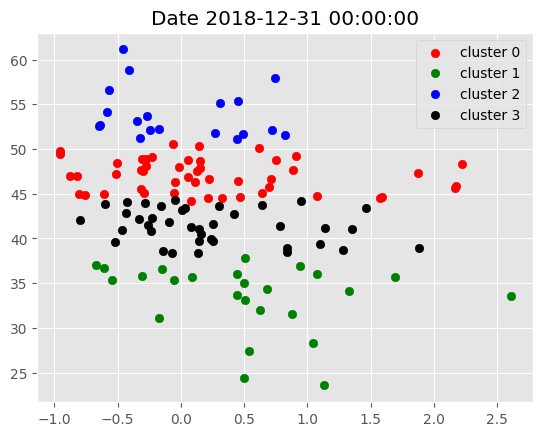

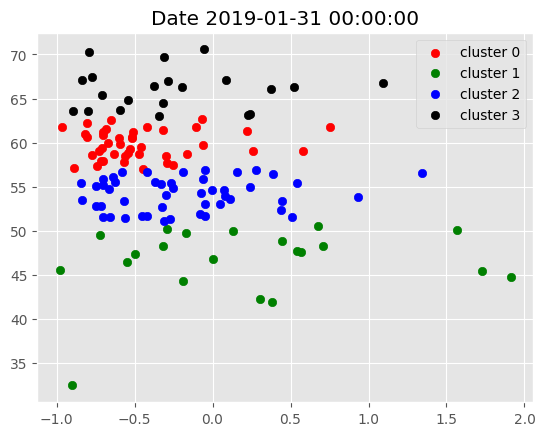

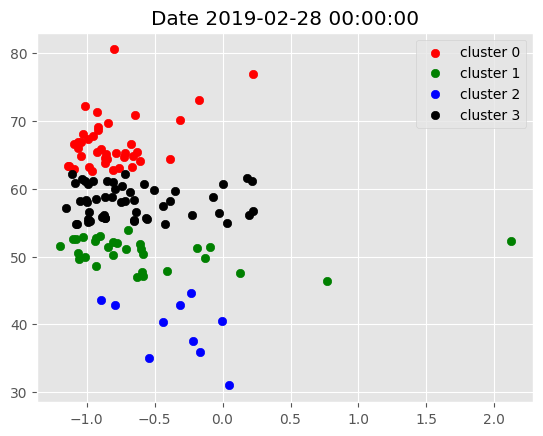

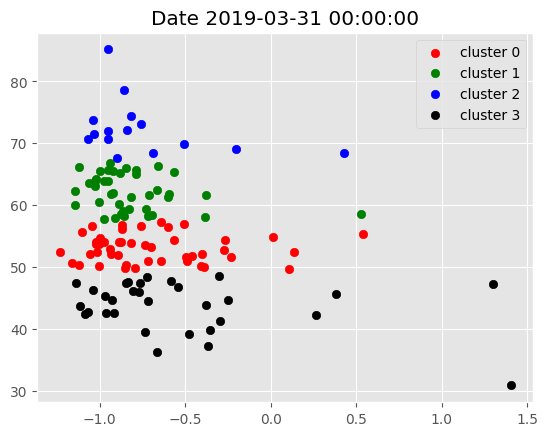

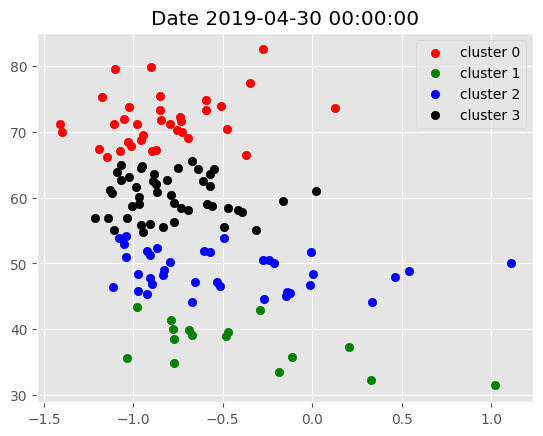

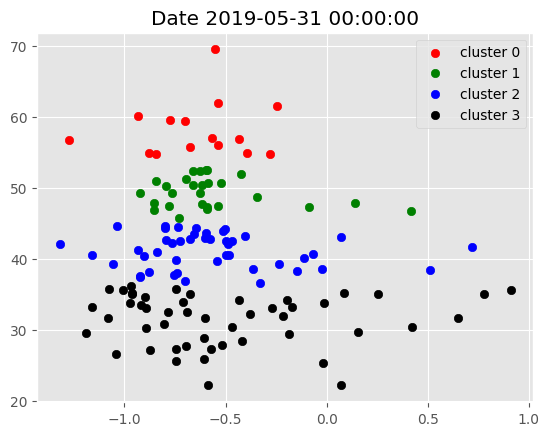

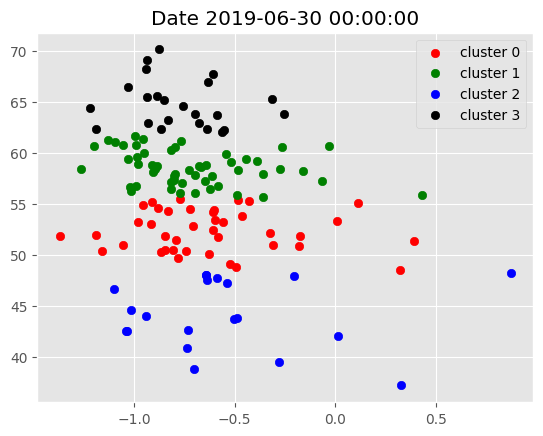

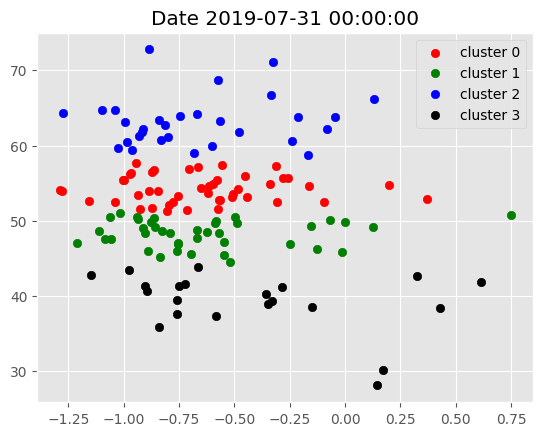

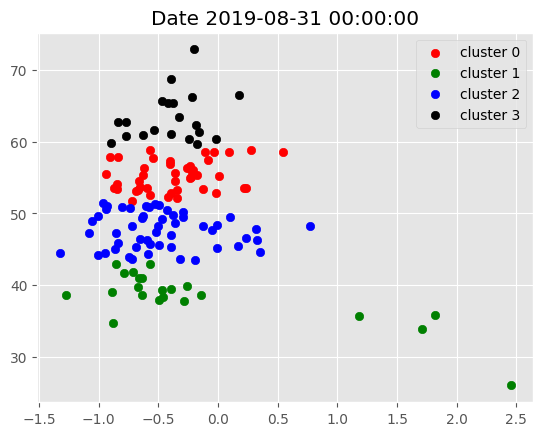

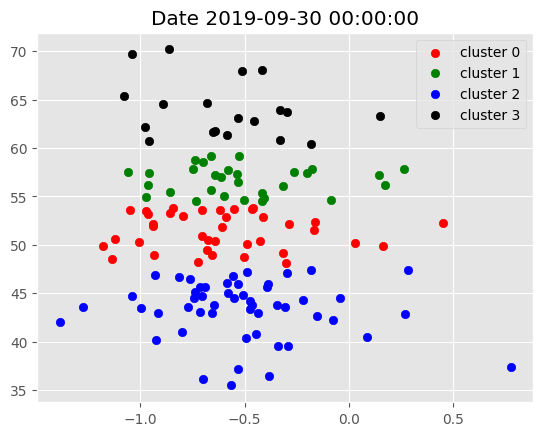

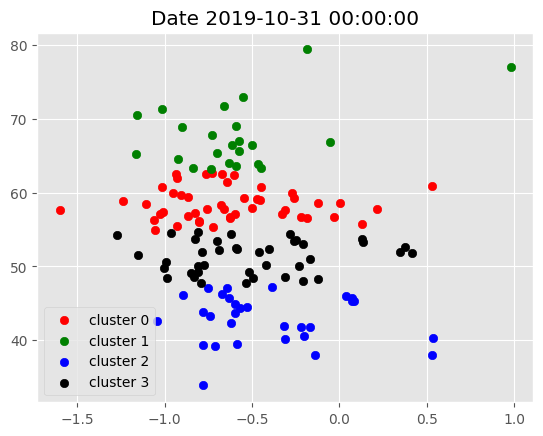

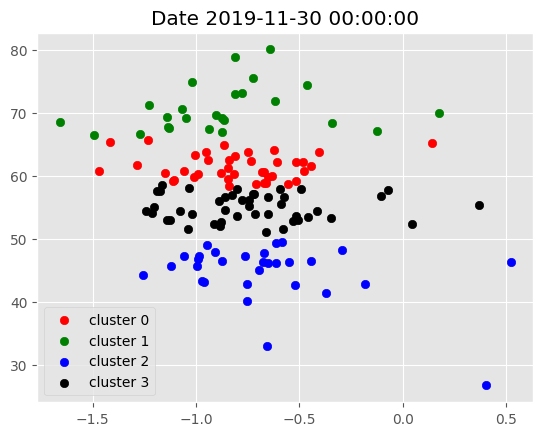

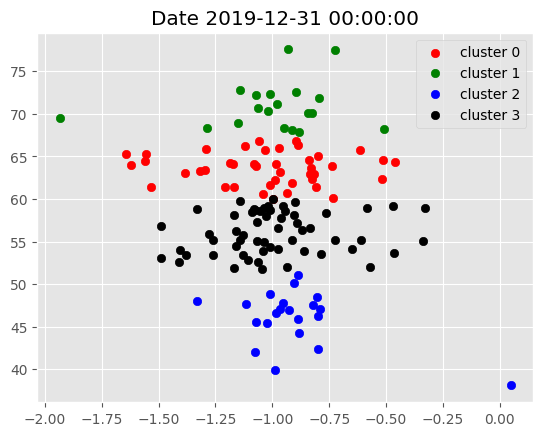

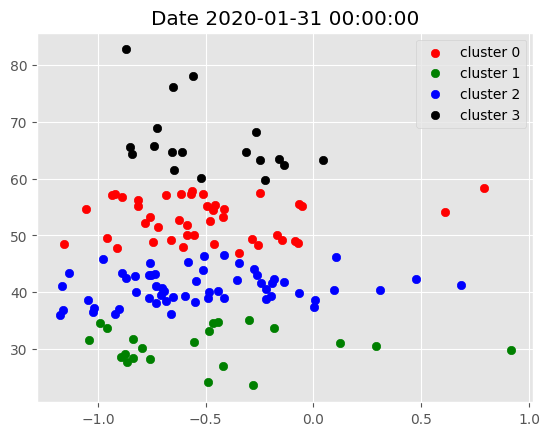

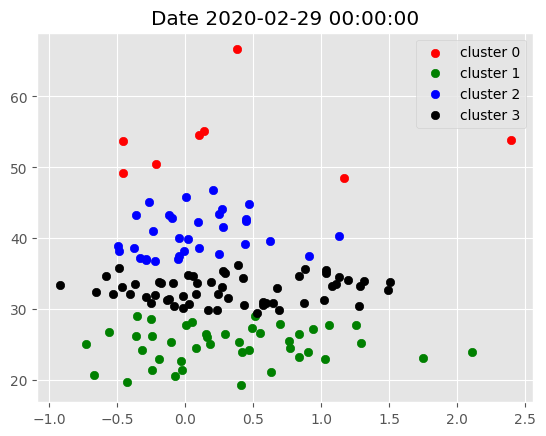

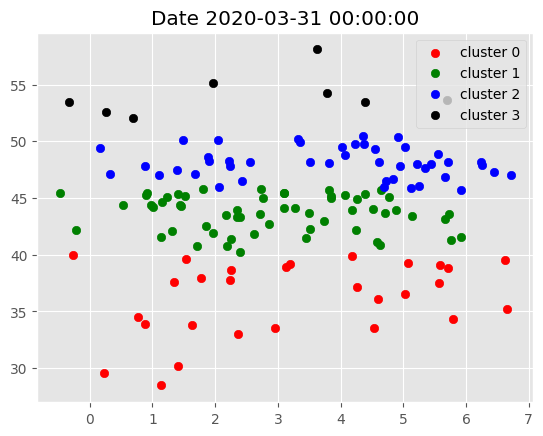

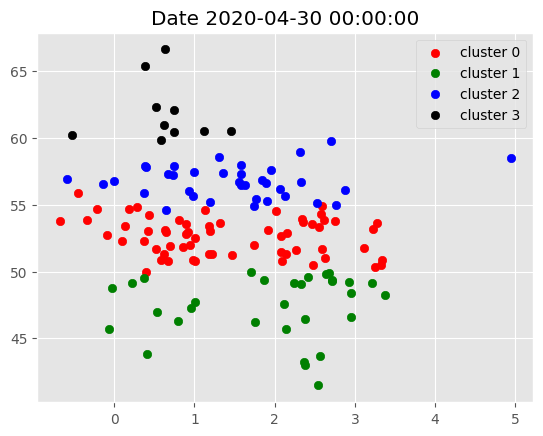

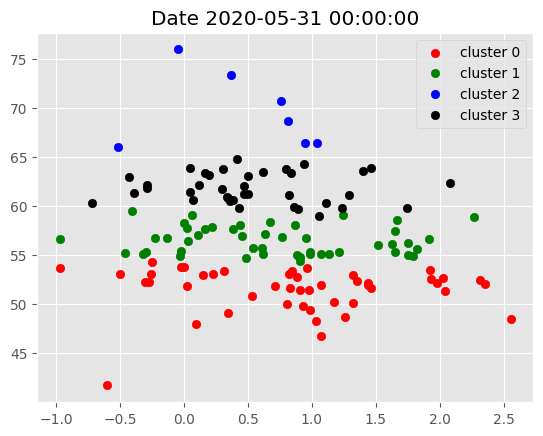

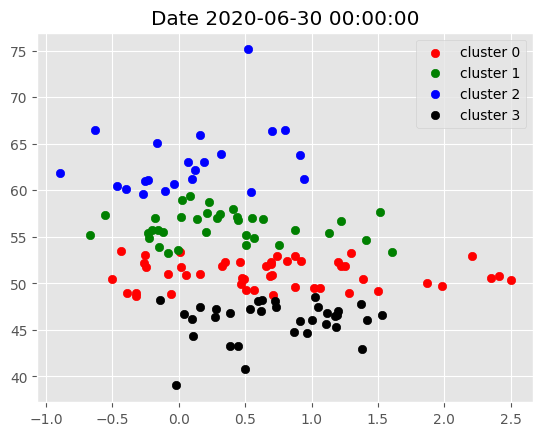

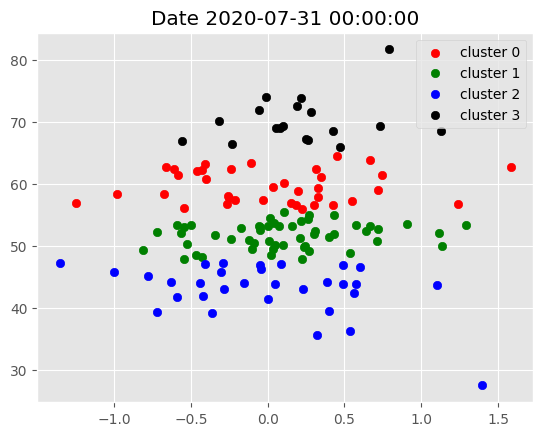

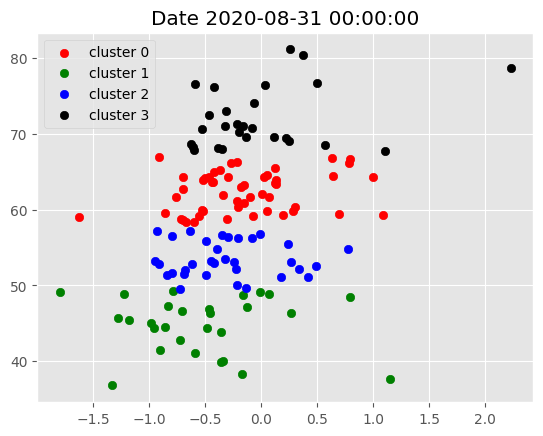

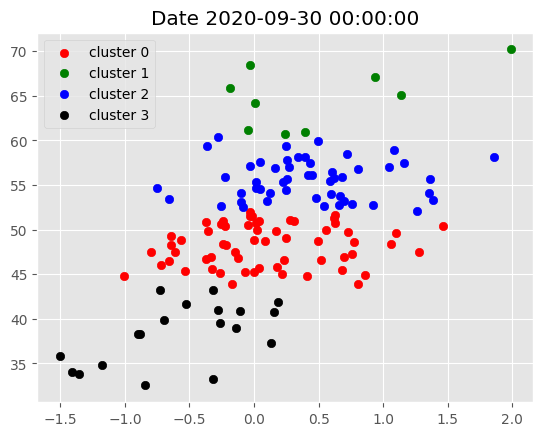

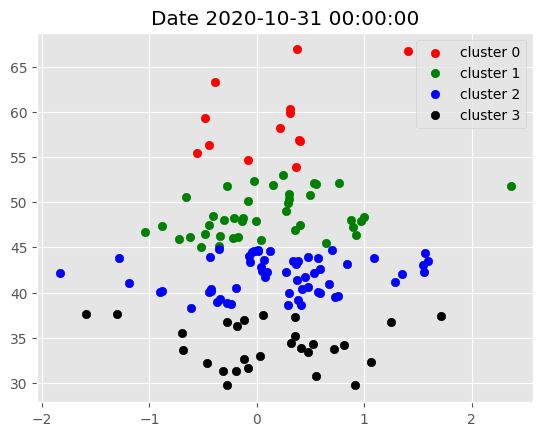

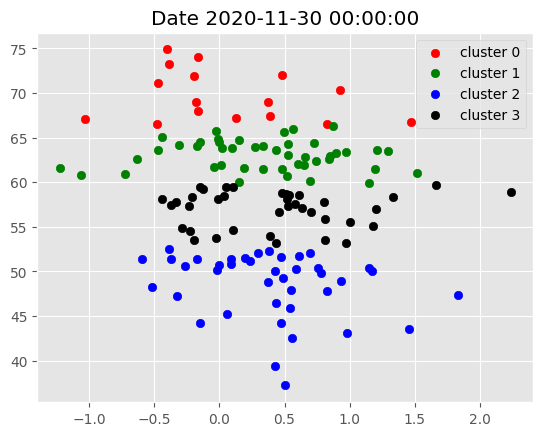

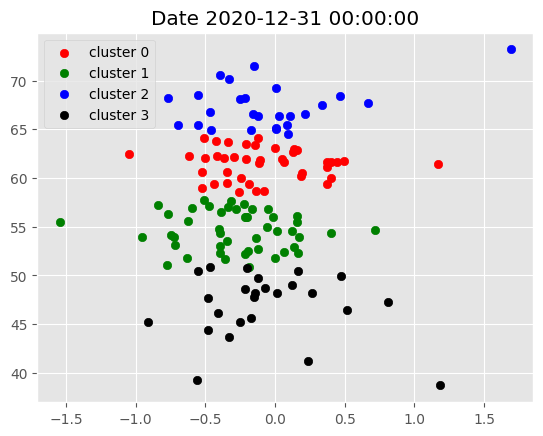

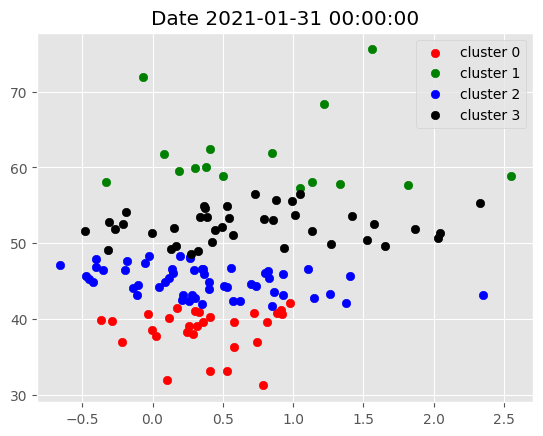

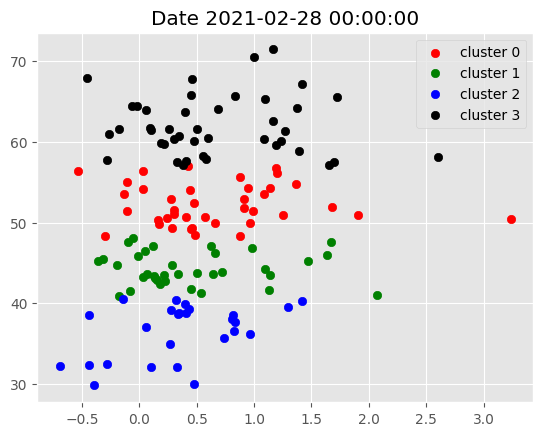

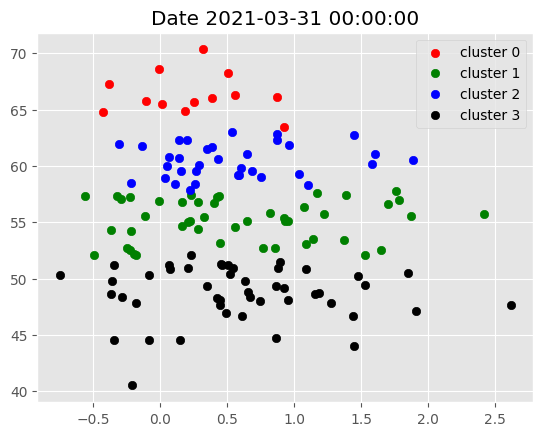

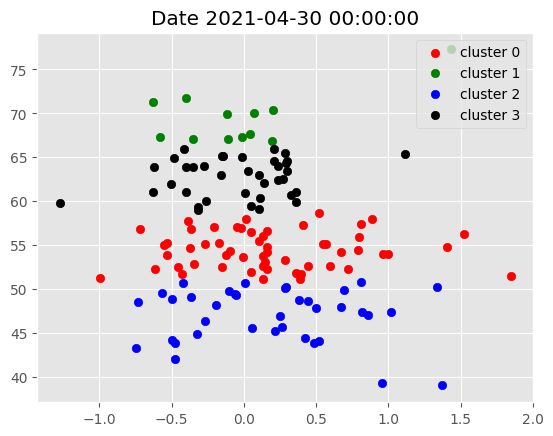

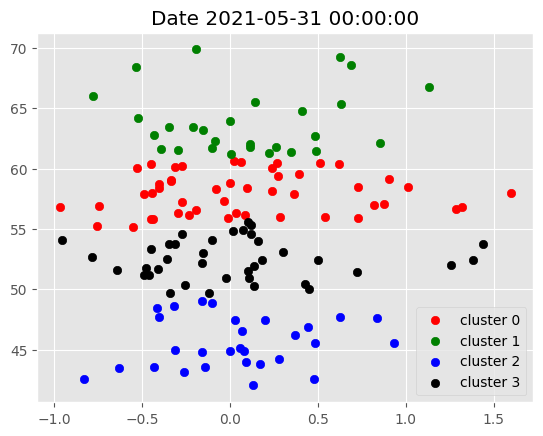

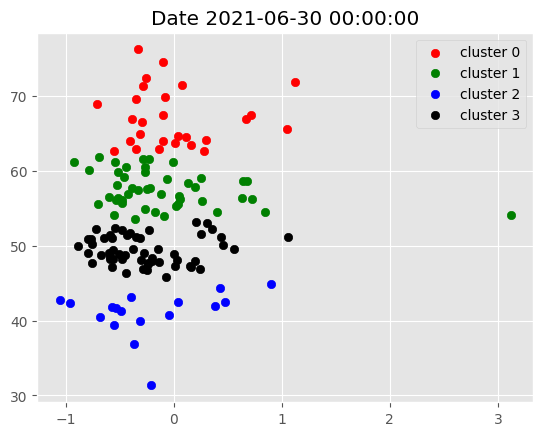

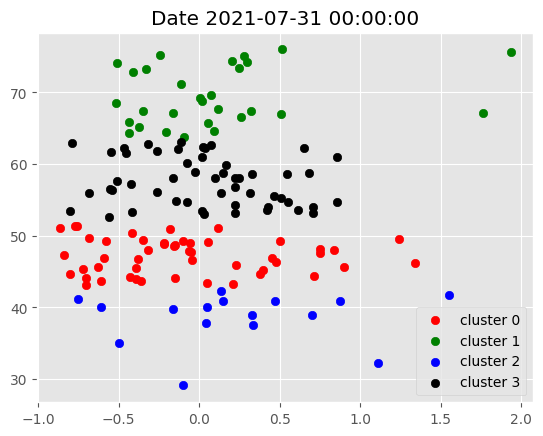

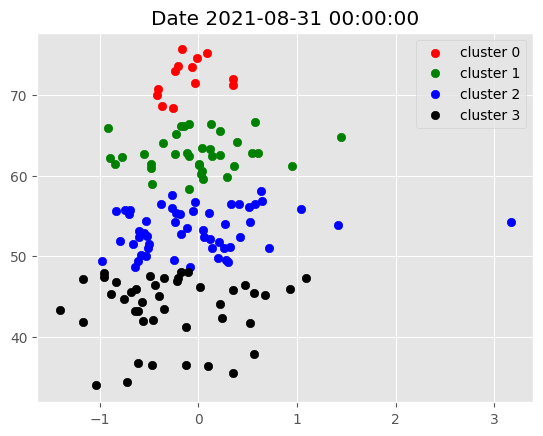

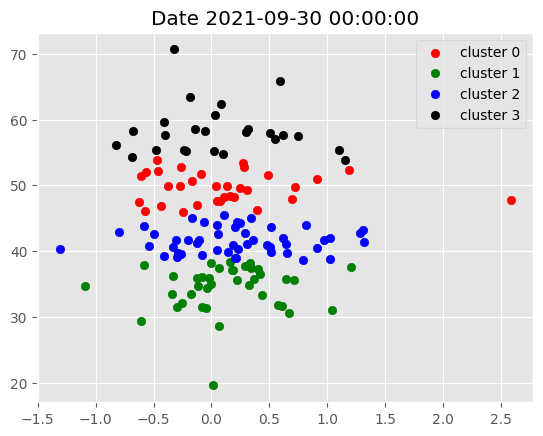

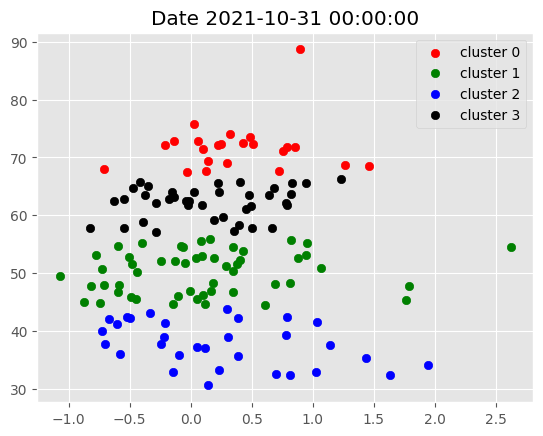

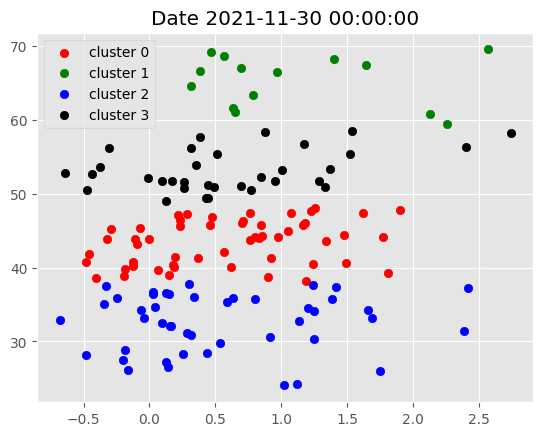

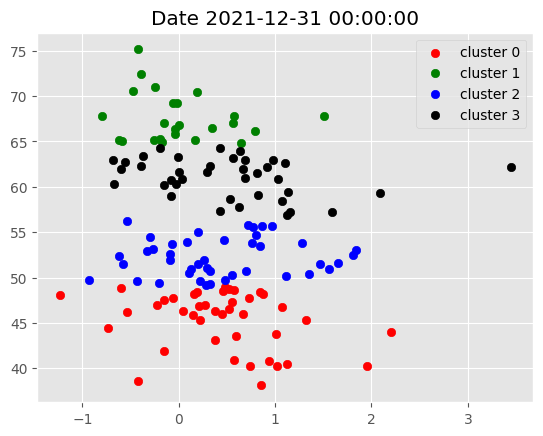

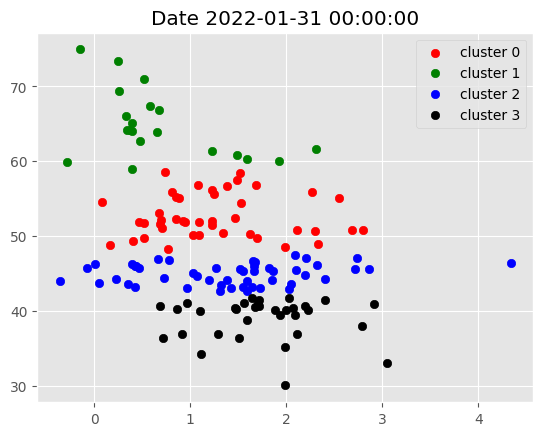

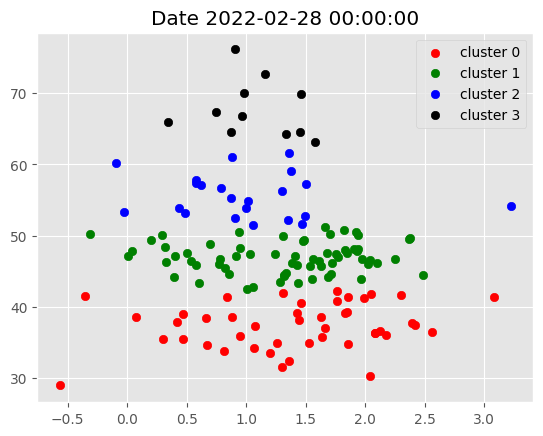

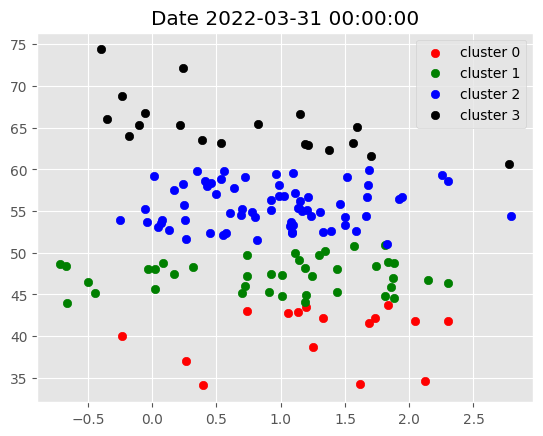

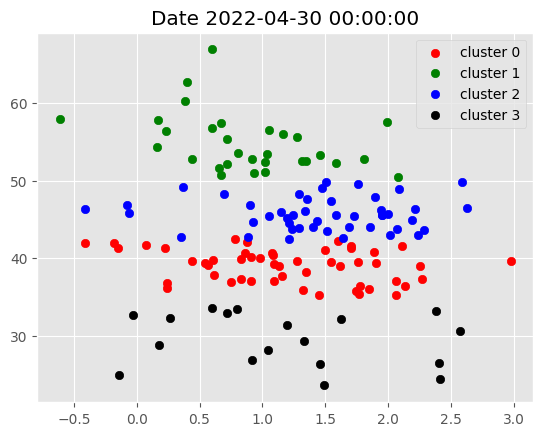

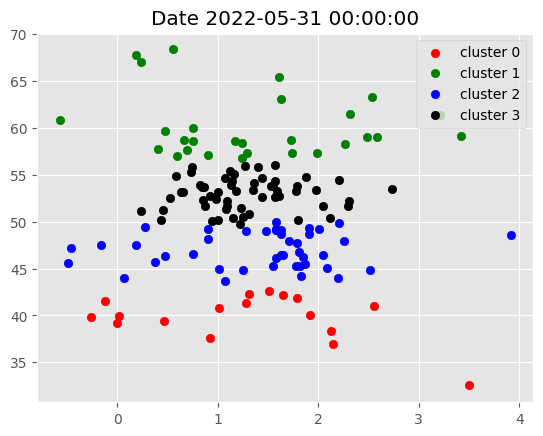

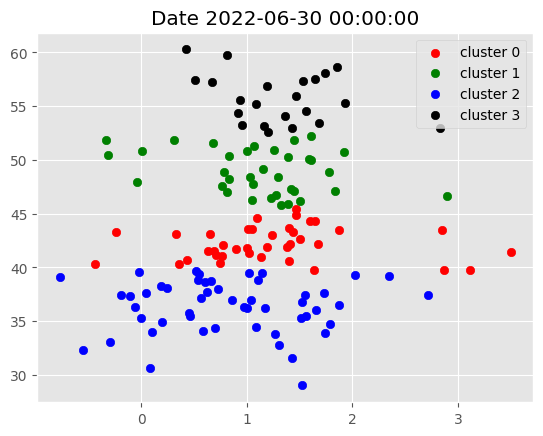

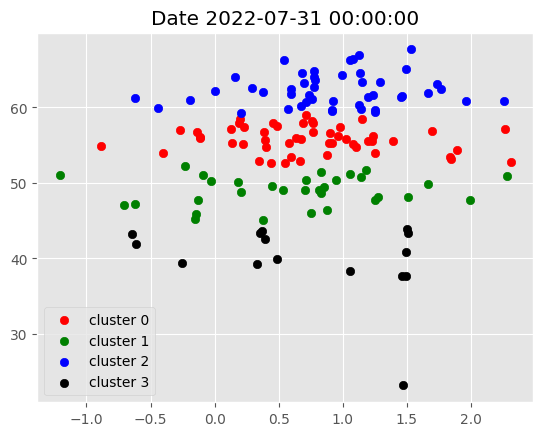

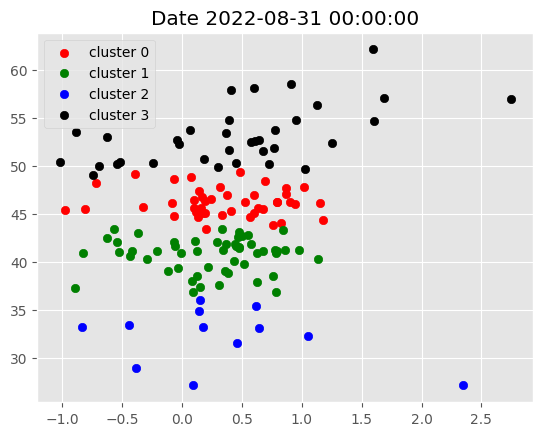

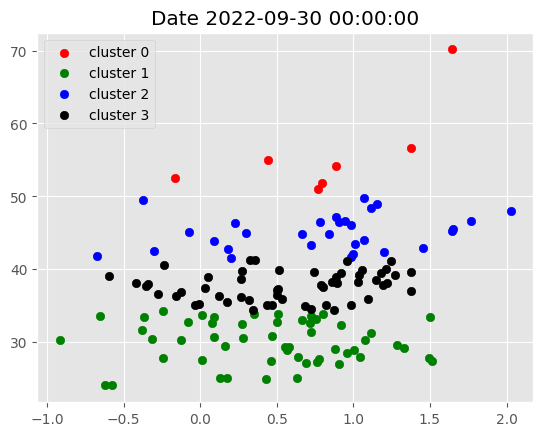

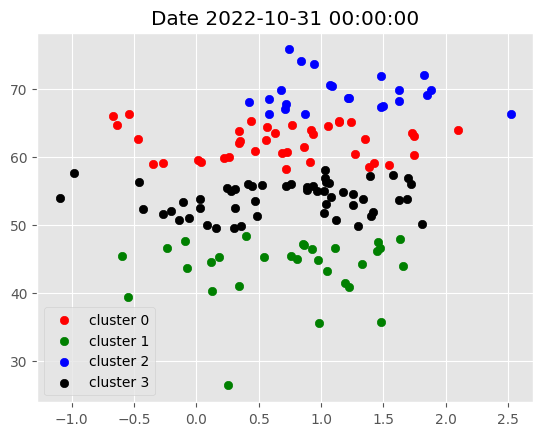

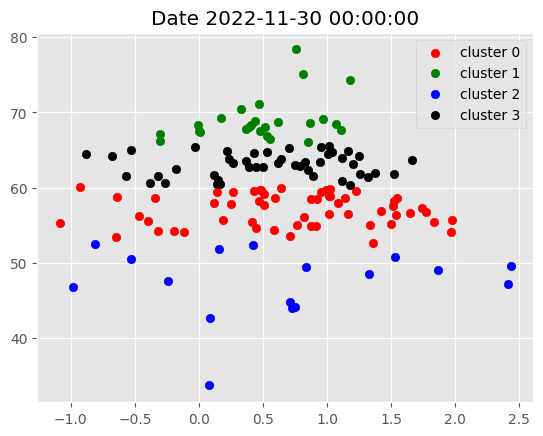

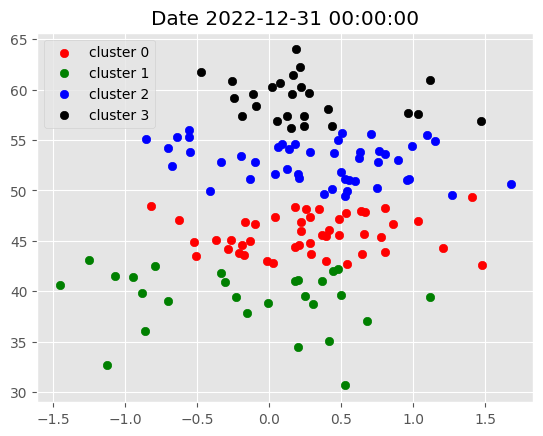

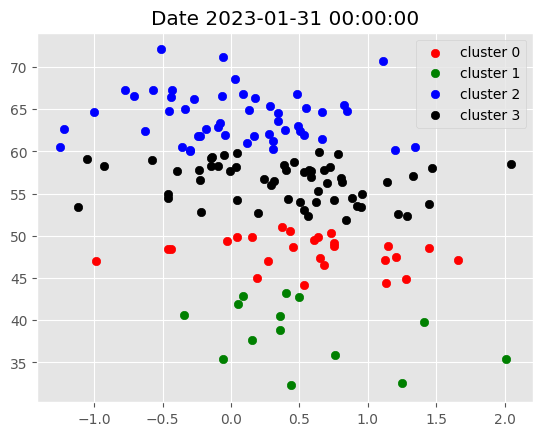

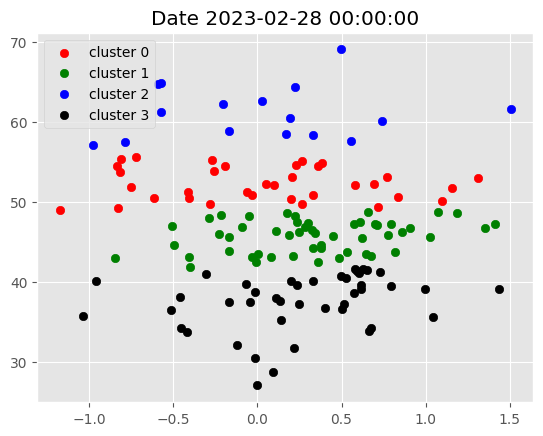

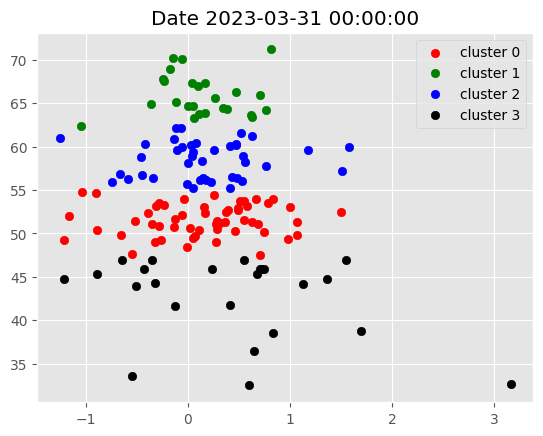

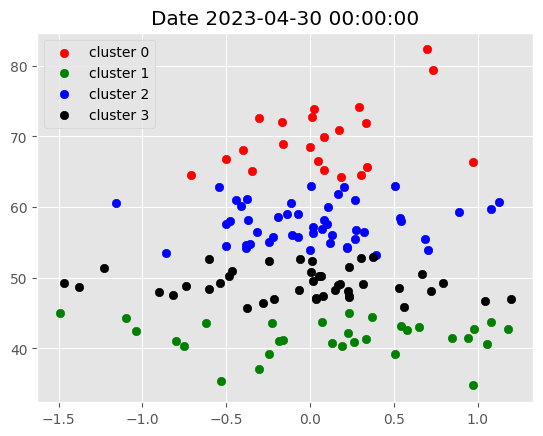

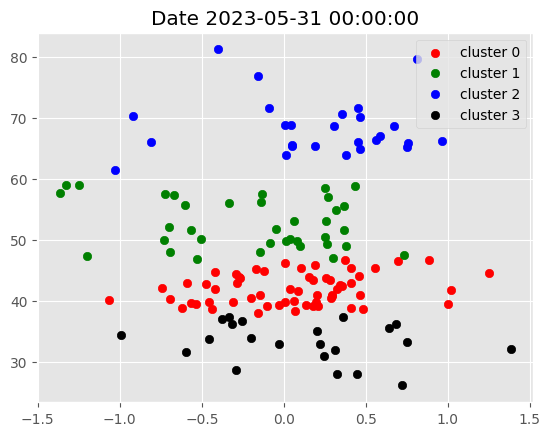

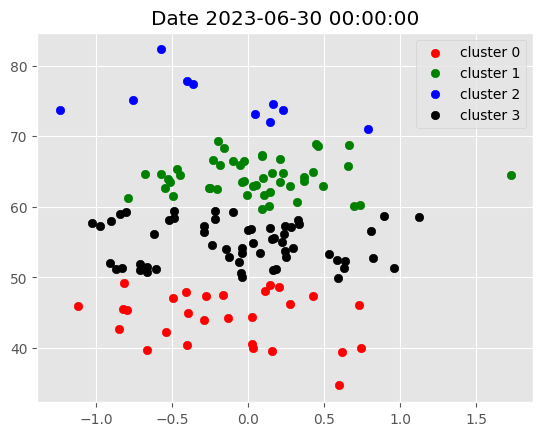

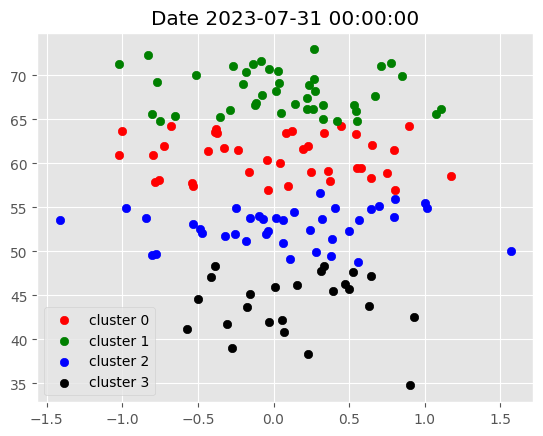

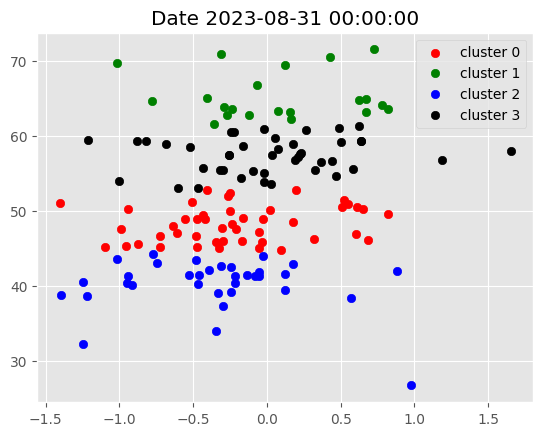

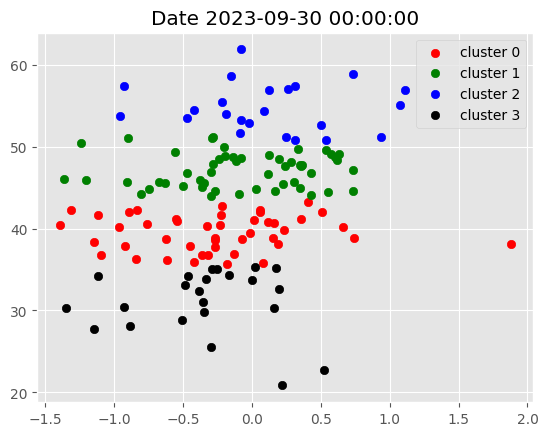

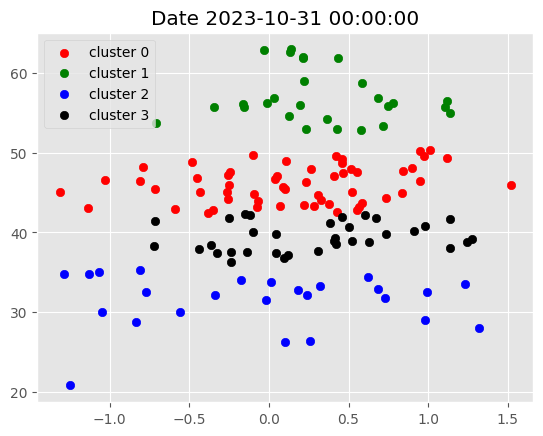

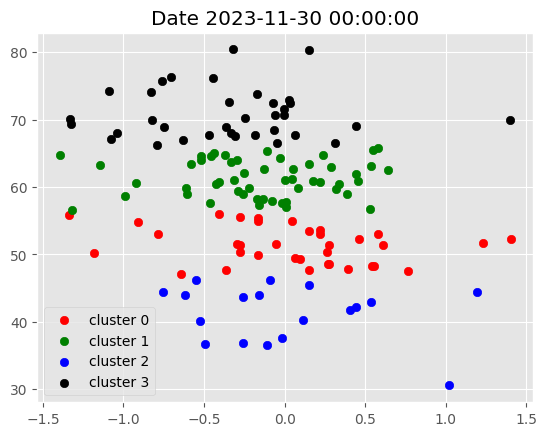

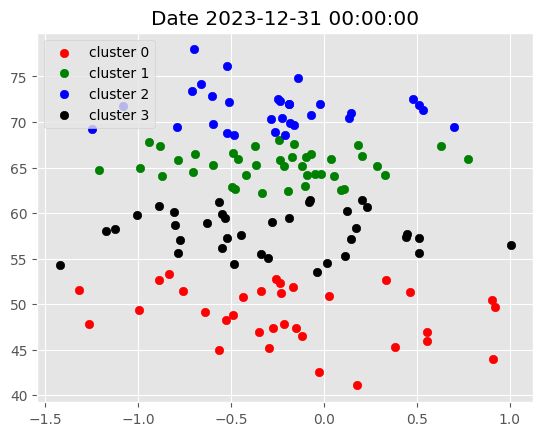

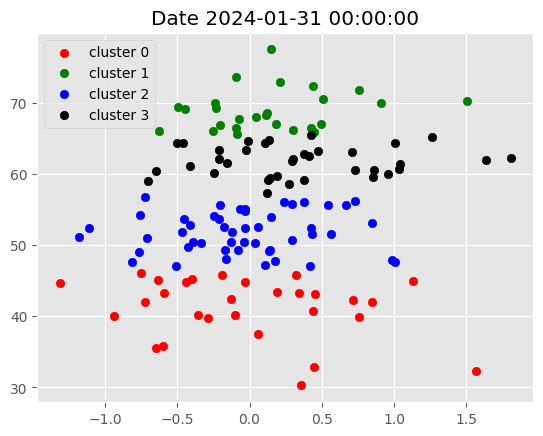

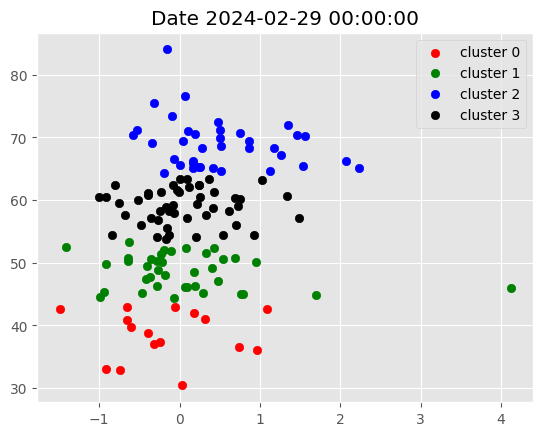

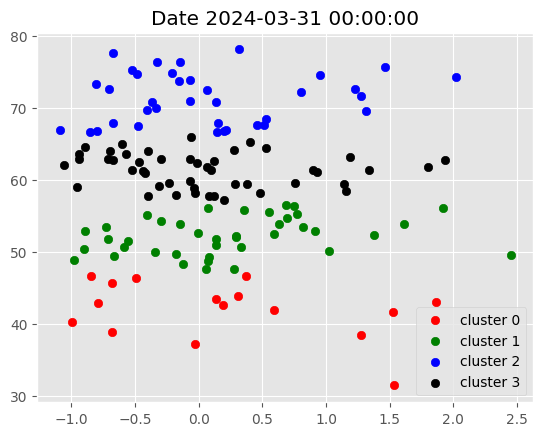

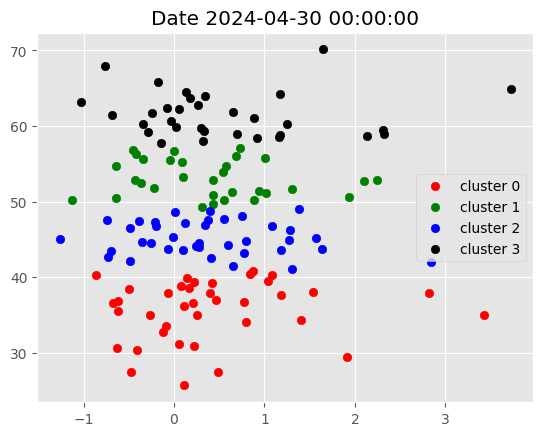

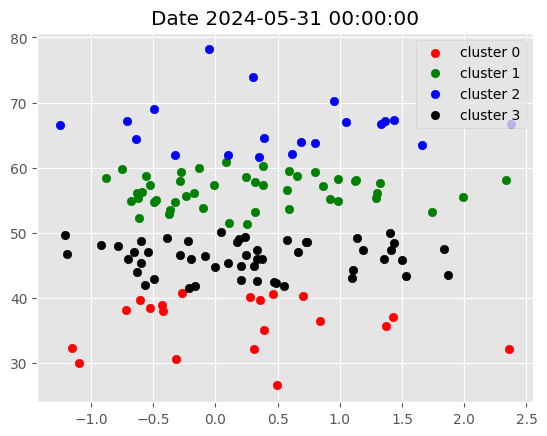

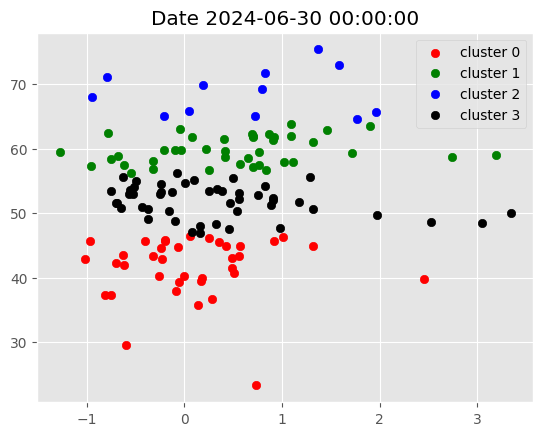

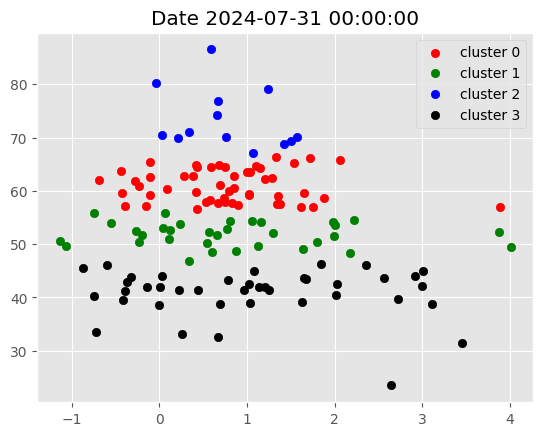

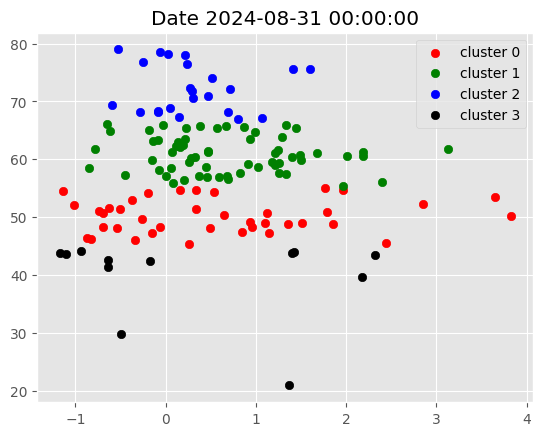

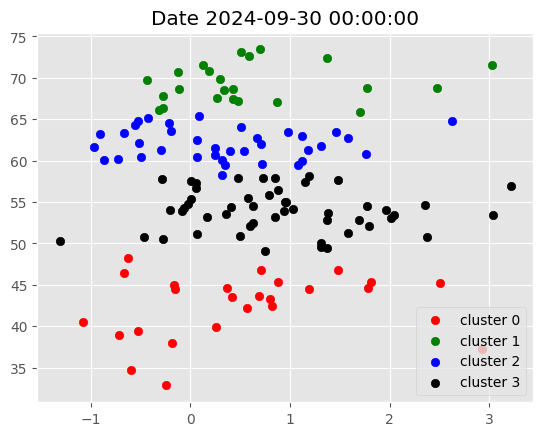

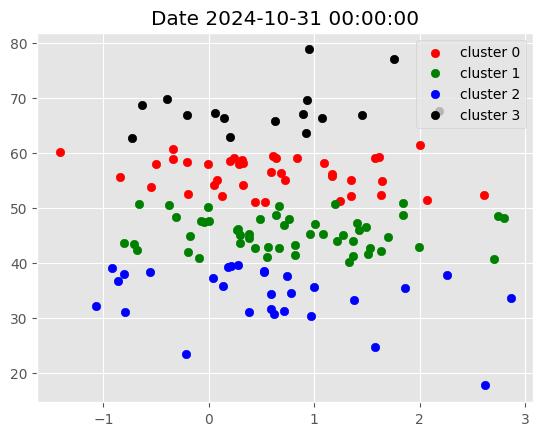

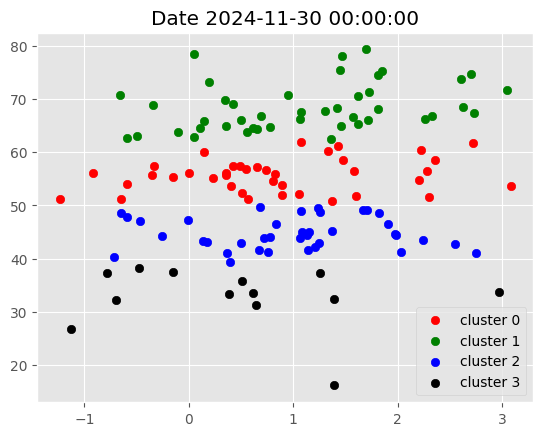

In [67]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Create pre defined centroids

In [68]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [69]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-12-31 AAPL           -0.000835  37.072851  3.585046  3.697134  3.809221   
           ABBV           -0.026539  57.957299  4.152361  4.223280  4.294199   
           ABT            -0.003189  55.190127  4.111693  4.169437  4.227180   
           ACN            -0.002485  36.633876  4.807611  4.940240  5.072869   
           ADBE            0.000161  46.330419  5.329066  5.452557  5.576047   
...                             ...        ...       ...       ...       ...   
2024-11-30 VRTX            0.000155  41.136384  6.090617  6.170690  6.250762   
           VZ              0.000209  57.378871  3.713802  3.747945  3.782089   
           WFC             0.000075  74.391809  4.137442  4.260497  4.383553   
           WMT             0.000209  74.711050  4.392675  4.445013  4.497350   
           XOM             0.000082  57.448623  4.751835  4.786490  4.821145   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.672172 -1.246500  -0.116698  -0.132912  -0.101245   
           ABBV    0.748414 -0.103455  -0.022064   0.088210  -0.004972   
           ABT     0.308224 -0.322310  -0.023228   0.024292  -0.003340   
           ACN    -0.151647 -1.466668  -0.142900  -0.054156  -0.057936   
           ADBE   -0.042862 -0.755168  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-11-30 VRTX    2.751680 -1.830256  -0.052544  -0.015286  -0.031155   
           VZ     -0.331598 -0.043189   0.024211  -0.012169   0.016046   
           WFC     1.816726  3.702242   0.176797   0.162932   0.093240   
           WMT     2.702822  2.779545   0.103600   0.058301   0.054043   
           XOM     0.427473  0.439478   0.051471   0.023486   0.013526   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.295933 -0.242619   
           ABBV     0.002641   0.000530   -0.000801  0.532860  0.324161   
           ABT      0.030303   0.022655    0.021488  0.760748 -0.049255   
           ACN     -0.022971  -0.007415   -0.005345  1.205518 -0.205539   
           ADBE    -0.012388   0.005118    0.021515  1.313358 -0.561885   
...                      ...        ...         ...       ...       ...   
2024-11-30 VRTX    -0.001606   0.007739    0.020186  0.497437  0.049636   
           VZ       0.013284   0.013771    0.015363  0.469319 -0.482855   
           WFC      0.042643   0.037496    0.047667  1.118617 -0.099997   
           WMT      0.055049   0.050330    0.044398  0.636942 -0.338441   
           XOM      0.009059   0.019885    0.017115  1.013796  0.061768   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628193  0.334861  0.500221        0  
           ABBV   -0.158059  0.413253  0.537524        1  
           ABT    -0.437457  0.169143  0.981046        1  
           ACN    -0.225972  0.351441  0.013451        0  
           ADBE   -0.255237  0.315773 -0.423941        2  
...                     ...       ...       ...      ...  
2024-11-30 VRTX   -0.771872  0.301048  0.797281        0  
           VZ      0.295900  0.136044  0.096860        3  
           WFC     1.573542 -0.692192 -0.965623        1  
           WMT    -0.363499  0.182730  0.622911        1  
           XOM     0.894621 -0.466599  0.371495        3  

[10136 rows x 19 columns]

### Select stocks based on our clustering algorithm to form a portfolio based on efficient frontier max sharpe ratio optimisation

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df